In [13]:
import sys
sys.path.append("..")

import utils.eeg_utils

import numpy as np
import matplotlib.pyplot as plt

import scipy.io

import h5py

from scipy import fft


import os
from os import listdir
from os.path import isfile, join, isdir

from nilearn import plotting
from nilearn import image
from nilearn import _utils
from nilearn.input_data import NiftiMasker
from nilearn.decomposition import CanICA
from nilearn.masking import apply_mask, compute_epi_mask, compute_multi_epi_mask, _apply_mask_fmri
from nilearn.image import smooth_img, index_img, iter_img, clean_img, math_img, mean_img, new_img_like


/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#mat = scipy.io.loadmat('file.mat')

dataset = '/home/davidcalhas/eeg_to_fmri/datasets/02/wEEG'

individual = '/sub001/EEG'

run = '/task001_run001/EEG_noGA.mat'

complete_path = dataset + individual + run

import scipy.io
eeg_file = scipy.io.loadmat(complete_path)

In [3]:
eeg_data = eeg_file['data_noGA']

In [4]:
fs = 1000

In [5]:
def plot_fft(eeg, channel=0, fs=1000, max_freq=30000, start_time=None, stop_time=None):
    y = eeg[channel][:]

    if(start_time == None):
        start_time = 0
    if(stop_time == None):
        stop_time = len(y)

    fft1 = compute_fft(y[start_time:stop_time], fs=fs)

    N = int(len(y[start_time:stop_time])/2)
    f = np.linspace (0, fs, N/2)

    plt.figure(1)
    plt.plot (f[1:max_freq], abs (fft1)[1:max_freq])
    plt.title ('Magnitude of each frequency')
    plt.xlabel ('Frequency (Hz)')
    plt.show()
    
def compute_fft(channel, fs=128):
    N = int(len(channel)/2)

    fft1 = fft(channel)

    return fft1[range(int(N/2))]

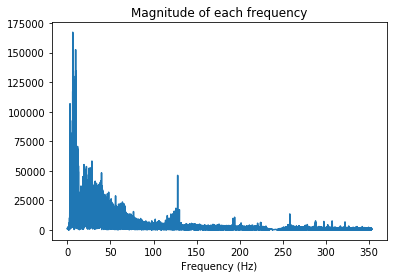

In [6]:
plot_fft(eeg_data, channel=5)

In [7]:
def stft(eeg, channel=0, window_size=2, fs=1000, start_time=None, stop_time=None):
    signal = eeg[channel][:]


    if(start_time == None):
        start_time = 0
    if(stop_time == None):
        stop_time = len(signal)
    signal = signal[start_time:stop_time]

    t = []



    fs_window_size = int(window_size*fs)


    Z = []
    seconds = 0
    for time in range(start_time, stop_time, fs_window_size):
        fft1 = compute_fft(signal[time:time+fs_window_size], fs=fs)

        N = len(signal[time:time+fs_window_size])/2
        f = np.linspace (0, len(fft1), N/2)

        #average
        Z += [list(abs(fft1[1:]))]
        t += [seconds]
        seconds += window_size

    return f[1:], np.transpose(np.array(Z)), t

def plot_stft(eeg, channel=2, window_size=2, min_freq=None, fs=1000, max_freq=None):
    f, Zxx, t = stft(eeg, channel=channel, fs=fs, window_size=window_size)

    if(min_freq == None):
        min_freq = 0
    if(max_freq == None):
        max_freq = len(Zxx)

    Zxx = Zxx[min_freq:max_freq]
    f = f[min_freq:max_freq]

    amplitude = np.max(Zxx)

    im = plt.pcolormesh(t, f, abs(Zxx), vmin=0, vmax=amplitude)

    plt.colorbar(im)
    plt.show()

In [8]:
def get_eeg_instance(individual, run=0, path_eeg='/home/david/eeg_informed_fmri/datasets/01/EEG/', preprocessed=True):

    individuals = sorted([f for f in listdir(path_eeg) if isdir(join(path_eeg, f))])
    print(individuals)
    
    path_eeg = path_eeg + '/' + individuals[individual] + '/EEG'
    
    runs = sorted([f for f in listdir(path_eeg) if isdir(join(path_eeg, f))])
    
    run = runs[run]

    if(preprocessed):
        path = path_eeg + '/' + run + '/EEG_noGA.mat'
    else:
        path = path_eeg + '/' + run + '/EEG_noGA.mat'


    eeg_file = scipy.io.loadmat(path)
    
    return eeg_file['data_noGA']

In [9]:
get_eeg_instance(13, run=4, path_eeg=dataset).shape

['sub001', 'sub002', 'sub003', 'sub004', 'sub005', 'sub006', 'sub007', 'sub008', 'sub009', 'sub010', 'sub011', 'sub012', 'sub013', 'sub014']


(49, 340000)

# Read the whole data from the subjects

In [10]:
def get_data(individuals, masker=None, start_cutoff=3, bold_shift=3, n_partitions=16, by_partitions=True, partition_length=None, n_voxels=None, f_resample=2, roi=None, roi_ica_components=None):
    TR = 1/2.160

    X = []
    y = []


    #setting ICA
    if(roi != None and roi_ica_components != None):
        individuals_imgs = fmri_utils.get_individuals_paths()
        roi_extraction = fmri_utils.roi_time_series()
        roi_extraction._set_ICA(individuals_imgs, n_components=roi_ica_components)

    for individual in individuals:
        eeg = get_eeg_instance(individual)
        x_instance = []
        #eeg
        for channel in range(len(eeg.ch_names)):
            f, Zxx, t = eeg_utils.stft(eeg, channel=channel, window_size=f_resample) 
            Zxx_mutated = eeg_utils.mutate_stft_to_bands(Zxx, f, t)

            x_instance += [Zxx_mutated]

        x_instance = np.array(x_instance)

        #fmri
        if(roi != None and roi_ica_components != None):
            fmri_masked_instance = roi_extraction.get_ROI_time_series(individuals_imgs[individual], component=roi)
        else:
            fmri_instance = fmri_utils.get_fmri_instance_img(individual)
            fmri_masked_instance, _ = fmri_utils.get_masked_epi(fmri_instance, masker)

        fmri_resampled = []
        #build resampled BOLD signal
        if(n_voxels == None):
            n_voxels = fmri_masked_instance.shape[1]

        for voxel in range(n_voxels):
            voxel = fmri_utils.get_voxel(fmri_masked_instance, voxel=voxel)
            voxel_resampled = resample(voxel, int((len(voxel)*(1/f_resample))/TR))
            fmri_resampled += [voxel_resampled]

        fmri_resampled = np.array(fmri_resampled)

        if(by_partitions):

            for partition in range(n_partitions):
                start_eeg = start_cutoff + int((fmri_resampled.shape[1]-start_cutoff-bold_shift)/n_partitions)*partition
                end_eeg = start_cutoff + int((fmri_resampled.shape[1]-start_cutoff-bold_shift)/n_partitions)*partition + int((fmri_resampled.shape[1]-start_cutoff-bold_shift)/n_partitions)

                start_bold = start_eeg+bold_shift
                end_bold = end_eeg+bold_shift

                X += [x_instance[:,:,start_eeg:end_eeg]]

                y += list(fmri_resampled[:,start_bold:end_bold].reshape(1, fmri_resampled[:,start_bold:end_bold].shape[0], fmri_resampled[:,start_bold:end_bold].shape[1]))
        else:
            total_partitions = fmri_resampled.shape[1]//partition_length
            for partition in range(total_partitions):

                start_eeg = start_cutoff + int((fmri_resampled.shape[1]-start_cutoff-bold_shift)/(total_partitions))*partition
                end_eeg = start_cutoff + int((fmri_resampled.shape[1]-start_cutoff-bold_shift)/(total_partitions))*partition + int((fmri_resampled.shape[1]-start_cutoff-bold_shift)/(total_partitions))

                start_bold = start_eeg+bold_shift
                end_bold = end_eeg+bold_shift

                X += [x_instance[:,:,start_eeg:end_eeg]]

                y += list(fmri_resampled[:,start_bold:end_bold].reshape(1, fmri_resampled[:,start_bold:end_bold].shape[0], fmri_resampled[:,start_bold:end_bold].shape[1]))
                
        print(np.array(y).shape)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [ ]:
def get_population_mask(path_fmri='/home/david/eeg_informed_fmri/datasets/01/fMRI/'):

    individuals = sorted([f for f in listdir(path_fmri) if isdir(join(path_fmri, f))])
    
    individuals_images = []
    
    target_affine = image.load_img(path_fmri + individuals[0] + '/BOLD/task001_run001/bold.nii.gz').affine
    target_shape = image.load_img(path_fmri + individuals[0] + '/BOLD/task001_run001/bold.nii.gz').shape
    target_shape = (target_shape[0], target_shape[1], target_shape[2])
    
    for individual in individuals:
        bold_dir = path_fmri + individual + '/BOLD/'
        runs = sorted([f for f in listdir(bold_dir) if isdir(join(bold_dir, f))])
        
        for run in runs:
            individual_path = bold_dir + run + '/bold.nii.gz'
        
            if(image.load_img(individual_path).affine[0][-1] != 0.0):

                fmri_image = image.resample_img(image.load_img(individual_path), target_affine=target_affine, target_shape=target_shape)

                individuals_images += [fmri_image]

    concatenated_imgs = image.concat_imgs(individuals_images)

    return NiftiMasker(compute_multi_epi_mask(individuals_images), standardize=True).fit(concatenated_imgs)


dataset = '/home/davidcalhas/eeg_to_fmri/datasets/02/wEEG/'

mask = get_population_mask(path_fmri=dataset)

In [20]:
#Load Data
eeg_train, bold_train = get_data(list(range(10)), masker=mask, 
                                 n_voxels=None, bold_shift=3, n_partitions=25, 
                                 by_partitions=False, partition_length=None,
                                 f_resample=2, roi=0, roi_ica_components=20)

NiftiMasker(detrend=False, dtype=None, high_pass=None, low_pass=None,
            mask_args=None,
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7ff91033ad68>,
            mask_strategy='background', memory=Memory(location=None),
            memory_level=1, sample_mask=None, sessions=None,
            smoothing_fwhm=None, standardize=True, t_r=None, target_affine=None,
            target_shape=None, verbose=0)